# Quickstart: Querying PDF With Chroma and LangChain

### A question-answering demo using Chroma DB and LangChain, powered by Vector Search

#### Pre-requisites:

You need a chroma Db and Ollama hosted llama3.2 to generate embeddings.

#### What you will do:

- Setup: import dependencies, provide secrets, create the LangChain vector store;
- Run a Question-Answering loop retrieving the relevant headlines and having an LLM construct the answer.

Install the required dependencies:

In [7]:
!pip install -q langchain

In [ ]:
!pip install PyPDF2 

Import the packages you'll need:

In [34]:
# LangChain components to use
from langchain.indexes.vectorstore import VectorStoreIndexWrapper


# Support for dataset retrieval with Hugging Face
from datasets import load_dataset

# To read PDF files
from PyPDF2 import PdfReader
from typing_extensions import Concatenate

# Load env file
from dotenv import load_dotenv
import os

## RAG Pipeline

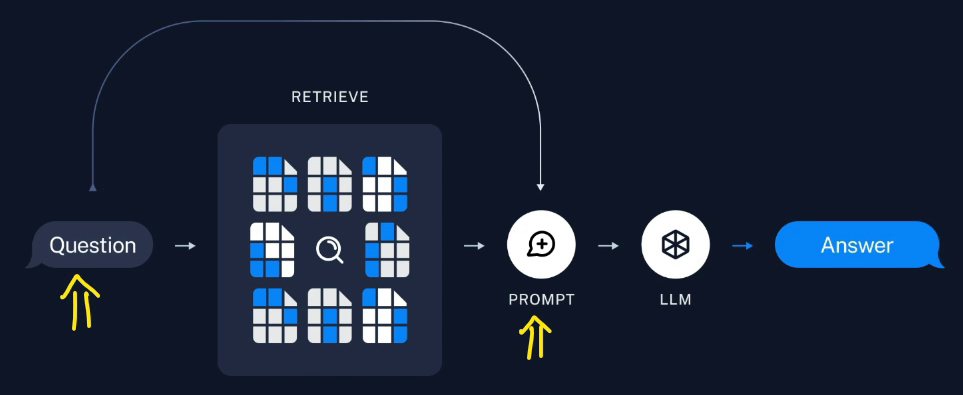


## Data loading process

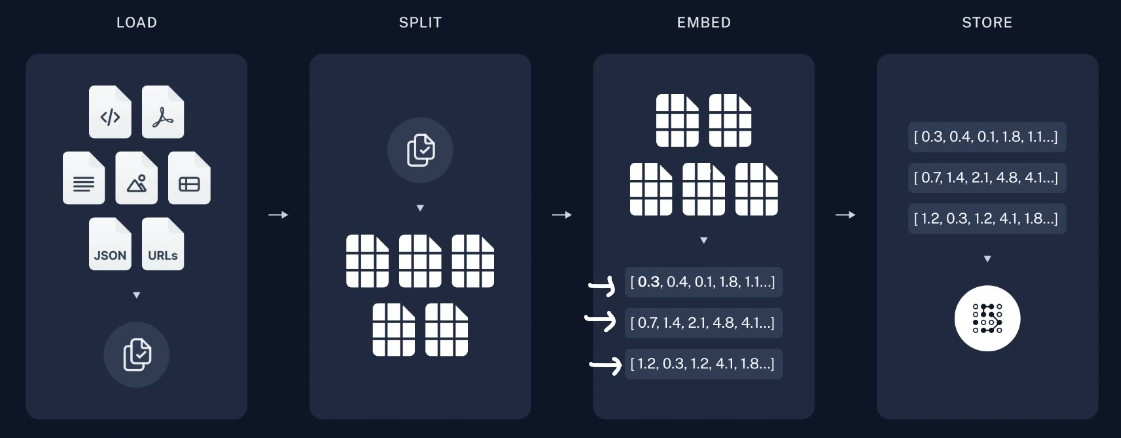

### Data Loading Setup

In [36]:
# provide the path of  pdf file/files.
pdfreader = PdfReader('data/Amazon SageMaker.pdf')

# read text from pdf
raw_text = ''
for i, page in enumerate(pdfreader.pages):
    content = page.extract_text()
    if content:
        raw_text += content

In [3]:
raw_text

'Amazon SageMaker\nDeveloper Guide\nAmazon SageMaker Developer Guide\nAmazon SageMaker: Developer Guide\nCopyright © 2019 Amazon Web Services, Inc. and/or its aﬃliates. All rights reserved.\nAmazon\'s trademarks and trade dress may not be used in connection with any product or service that is not\nAmazon\'s, in any manner that is likely to cause confusion among customers, or in any manner that disparages or\ndiscredits Amazon. All other trademarks not owned by Amazon are the property of their respective owners, who may\nor may not be aﬃliated with, connected to, or sponsored by Amazon.Amazon SageMaker Developer Guide\nTable of Contents\nWhat Is Amazon SageMaker?...............................................................................................................1\nAre You a First-time User of Amazon SageMaker?..........................................................................1\nHow It Works.................................................................................

In [37]:
len(raw_text)

1917659

In [38]:
# !set PYTHONHTTPSVERIFY=0

Create the LangChain embedding and LLM objects for later usage:

In [ ]:
# Method 1
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
embeddings = HuggingFaceEndpointEmbeddings()

sentence = "Hello when do you think a major epedemic like corona will come again"

query_result = embeddings.embed_query(sentence)
print(len(query_result))

In [ ]:
# Method 2
import requests

headers = {
    "Content-Type": "application/json",
}

url = "https://ollama.aes.zdidata.com/api/embed"

payload = {
        "model": "llama3.2:3b",
        "input": "Why is the sky blue?"
    }
response = requests.post(url, json=payload, headers=headers)
# print(response.json()['embeddings'])
print(len(response.json()['embeddings'][0]))

In [1]:
# Required method to create embeddings
# from langchain_community.embeddings import OllamaEmbeddings
from langchain_ollama import OllamaEmbeddings

# ollama_emb = OllamaEmbeddings(base_url="https://ollama.aes.zdidata.com",
#     model="llama3.2:3b",
#     client_kwargs={"verify": False}
# )

from int_host_emd import ollama_emb

r1 = ollama_emb.embed_documents(
    [
        "Alpha is the first letter of Greek alphabet",
        "Beta is the second letter of Greek alphabet",
    ]
)
r2 = ollama_emb.embed_query(
    "What is the second letter of Greek alphabet"
)

In [4]:
print("Length of embedding: ", len(r2))
r2

Length of embedding:  3072


[-0.02017921,
 -0.013658828,
 -0.0008308421,
 -0.0026884815,
 0.019890182,
 -0.0022861778,
 -0.0031233635,
 0.025057241,
 -0.021075722,
 -0.0031690812,
 -0.003463068,
 -0.025344482,
 0.03000001,
 0.05506522,
 0.0042035263,
 -0.022594823,
 0.008170241,
 -0.008432729,
 0.0011287716,
 0.012668729,
 -0.013176354,
 -0.0028193383,
 0.023240093,
 -0.007007826,
 -0.032376673,
 0.003794477,
 0.0056222444,
 -0.02154562,
 0.0051820977,
 0.005617853,
 0.017775832,
 0.013087684,
 -0.012885289,
 0.0004963706,
 0.003259529,
 -0.0029220874,
 0.00057361525,
 0.011833868,
 -0.021017304,
 -0.016396884,
 -0.026990136,
 -0.01683987,
 0.029663743,
 -0.001968664,
 -0.014408622,
 -0.01553029,
 0.018189482,
 -0.007003698,
 0.00028999776,
 0.011856442,
 0.020064771,
 0.0065921033,
 -0.021112548,
 -0.009763934,
 -0.007839793,
 0.001783592,
 0.022440184,
 -0.028106127,
 0.0041524377,
 -0.0156511,
 0.016636377,
 0.03052028,
 0.014065418,
 0.0049007647,
 0.06978776,
 -0.029013315,
 -0.0016942346,
 0.027681623,
 -0.

Create your LangChain vector store ... backed by Chroma DB!

In [42]:
from langchain.text_splitter import CharacterTextSplitter

# We need to split the text using Character Text Split such that it sshould not increse token size
text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 800,
    chunk_overlap  = 200,
    length_function = len,
)
texts = text_splitter.split_text(raw_text)

In [43]:
len(texts)

3204

In [10]:
texts[:50]

["Amazon SageMaker\nDeveloper Guide\nAmazon SageMaker Developer Guide\nAmazon SageMaker: Developer Guide\nCopyright © 2019 Amazon Web Services, Inc. and/or its aﬃliates. All rights reserved.\nAmazon's trademarks and trade dress may not be used in connection with any product or service that is not\nAmazon's, in any manner that is likely to cause confusion among customers, or in any manner that disparages or\ndiscredits Amazon. All other trademarks not owned by Amazon are the property of their respective owners, who may\nor may not be aﬃliated with, connected to, or sponsored by Amazon.Amazon SageMaker Developer Guide\nTable of Contents\nWhat Is Amazon SageMaker?...............................................................................................................1",
 'Table of Contents\nWhat Is Amazon SageMaker?...............................................................................................................1\nAre You a First-time User of Amazon SageMaker?..........

### Load the dataset into the vector store



In [69]:
from langchain_chroma import Chroma
from int_host_emd import ollama_emb

vectordb=Chroma.from_texts(texts=texts[:10], embedding=ollama_emb)
vectordb

# To create a persistent directory
# db = Chroma.from_texts(texts=texts[:100], embedding=ollama_emb, persist_directory="./chroma_db")

In [66]:
print(len(vectordb.get()["documents"]))

160


In [54]:
## query the database
query = "How to use ML pipeline in Sagemaker"
docs = vectordb.similarity_search(query)

print(len(docs))
print(docs[0].page_content)

4
•Use a Jupyter notebook on an Amazon SageMaker notebook instance. You can also use the notebook
instance to do the following:
•Write code to create model training jobs
•Deploy models to Amazon SageMaker hosting
•Test or validate your models
For more information, see Use Notebook Instances (p. 36)
•You can use a model to transform data by using Amazon SageMaker batch transform. For more
information, see Step 6.2: Deploy the Model with Batch Transform (p. 28).
How It Works: Next Topic
Train a Model with Amazon SageMaker  (p. 4)
Train a Model with Amazon SageMaker
The following diagram shows how you train and deploy a model with Amazon SageMaker:
4Amazon SageMaker Developer Guide
Model Training
The area labeled Amazon SageMaker highlights the two components of Amazon SageMaker: model


In [70]:
# To add other data as well to vector db
vectordb.add_texts(texts[100:150])

print("Inserted %i headlines." % len(texts[100:150]))

vectordb_index = VectorStoreIndexWrapper(vectorstore=vectordb)

Inserted 50 headlines.


## Load data from a stored chroma db 

In [1]:
from langchain_chroma import Chroma
from int_host_emd import ollama_emb
import json

games_db = Chroma(persist_directory="./chroma_db/sagemaker", embedding_function=ollama_emb)
coll = games_db.get() # Gets all the data it will not show the embeddings
print(coll)

# the json file where the output must be stored
out_file = open("./json/test.json", "w")

json.dump(coll, out_file)

out_file.close()

{'ids': ['c4a0256f-7e13-46b1-bede-c00f59bcb96d', '4f86ff62-7ffd-41fb-858e-e9dfe22ae4d8', 'ebe6bbb3-f2fe-4e38-a1bc-20476930eb15', '76c9e93c-b6f8-4382-a1d6-6fc0a5c1ff4f', '5ae63c9f-043c-4c5a-b19e-de71004d87bf', 'e05b9237-4afe-4eca-934c-71edde2df4f4', '2789b5de-e541-423b-b095-d1881444250b', '2bd36fcc-7e0d-4d5c-a2d4-3f2ed4d1d39b', 'bf0b18d5-78a0-45fd-9e92-030abd0da15a', '23b43fda-abc6-4eec-b730-c6b6a51b8ca4', 'cd926745-b2c1-4080-b9f6-86e29bd488ad', '9047947b-28a8-468c-b09f-00f5afd4bdf2', 'e652c881-a93e-402e-84d4-2f745bebc9f8', 'e92723cc-ca5f-4511-9776-fefb2efb3155', '3cbecfec-6b8b-481d-8c4f-f7b15323269a', 'ddd31977-3b76-473d-80da-32f160fdfb29', 'c40939e7-5819-4676-aee2-1b811fb435e7', '24d0f698-2572-490c-af31-f57b58838a31', '6b6b8d30-3b8f-4416-a4f7-88c883c87577', '62c5ec5e-3aff-4255-b4f3-11df423e590c', '908e9b1c-0b98-4540-8236-80d33a8b7f95', 'ef1762fa-e6cf-4656-abeb-2ca21cc5129f', '54c49bef-0888-4ee1-8da8-10ce1da35a60', 'ea035f26-bd6a-4426-ab6b-e74031e5dd7d', 'bfaa35ec-a63e-4b43-9cf4-8d1e20

In [10]:
# To view the stored embeddings as well we need to call the get function below shown method
data_with_emd = games_db._collection.get(include=['embeddings'])
print(data_with_emd["embeddings"][0])

[ 0.00187452 -0.00159323  0.059373   ...  0.00077881 -0.00433228
  0.00565044]


In [2]:
print(len(coll["documents"]))
print(coll["documents"][35])

300
vAmazon SageMaker Developer Guide
Get Information for a Script ............................................................................................395
Get Started with Containers....................................................................................................396
Pre-built Docker Images - Deep Learning...................................................................................398
Pre-built Docker Images - Scikit-learn and Spark ML...................................................................401
Example Notebooks ................................................................................................................402
Use Your Own Training Algorithms...........................................................................................404


In [22]:
overlap_text = "ways to strengthen phonemic awareness skills, drill phonograms, build reading fl  uency, practice spelling,"
print(len(overlap_text))

107


In [7]:
# Query the data from stored chroma db using embeddings
# This is a better approach to do so
query = "How to play reading robot"
emd_query = ollama_emb.embed_query(query)
docs = games_db.similarity_search_by_vector(emd_query)

print(len(docs))
print(docs[0].page_content)

4
room.  
 
 
 The student picks up one card and reads the word 
out loud. He walks around the room searching for a 
match. When he finds the matching card, he picks 
it up and reads the word out loud. If he reads the 
word correctly, he may go and find another word 
to match. If he does not read the word correctly, he 
tries again, with help from the teacher as needed. 
When he finds and reads all the matches, he wins!
Group
Choose high-frequency words for the students 
to practice and write each word on two index 
cards. Make at least five pairs per student. Tell the 
students how many matches they should each find, 
based on the number of cards you use. Scatter the 
cards around the room.  
 
 
 
 
 
 
 Each student picks up one card and reads the word


## Testing chroma database

In [58]:
from langchain_chroma import Chroma
from int_host_emd import ollama_emb
import json

games_db = Chroma(persist_directory="./chroma_db/games", embedding_function=ollama_emb)
test_coll = games_db.get() # Gets all the data
print(test_coll)

# the json file where the output must be stored
out_file = open("./json/games.json", "w")

json.dump(test_coll, out_file)

out_file.close()

{'ids': ['129fcd36-3e5f-4c9f-a50c-4c11bf406401', '2263f44f-1894-4831-ad02-90b9060f5fc6', '2f047ab4-5cf2-4337-9eac-9a6ded13d531', 'e9b50aed-6447-46f3-bac2-eb10eb970c39', '1e9407e0-289c-4c86-af51-e1fd1fcc2070', 'c37f405c-be2b-46cc-be02-c0bfef489bd1', 'f6d52f0f-bdf1-4083-a68f-1036b791380d', 'dd342b92-deef-44d1-8005-116572c85ecd', '5bdad790-ef78-4fae-971e-3b00bc300521', '4a8e310e-0578-49f8-8dbe-dfefb9a59259', '59513662-76b2-4fd1-bade-62335c577f55', '5dc02bc5-b7fa-417d-98e3-921ca65ae437', '8159395f-08cb-410c-93ee-fb80107f9bc9', 'a97ce6ad-bc2f-44c0-a70c-95c3eb35a95d', 'bc753395-71fb-4963-8be0-952a596821f0', 'f9801d00-0ba2-43c9-8bac-064849d8290b', '069a6985-3701-4f03-9109-736cddf464f9', 'ec94bbfe-36a5-49e7-87ef-9798b38dce51', '26bcccca-bb44-4906-a81c-fbda17533e6d', 'f2218899-0ddd-4f1c-a516-11c00c16e8ae', 'ca5ebf72-06cf-4713-925c-0bb5fd09aaec', '2344c279-5a89-4a09-b58e-839250c56495', 'ab0b5ab0-1029-4b9e-b4a1-d71c6951310a', '9e1a8b84-7a19-42cd-b7da-ea06ba6a9792', '4fadfa65-5900-4280-8fc1-5f1051

In [59]:
print(ollama_emb.embed_query("Test input"))

[-0.0007629191, -0.016017204, 0.05964438, -0.0065586194, -0.00035870256, -0.0204869, 0.008895703, -0.0019428431, -0.006383767, -0.016018713, -0.011643511, 0.01574233, 0.037187207, 0.02299433, -0.003175757, -0.003256909, -0.01675641, 0.01246609, -0.024588313, -0.022870384, -0.02053404, -0.0028706589, -0.012288395, -0.011708509, 0.020974858, -0.006391835, 0.01123614, -0.007962558, 0.015125625, 0.009852555, 0.020684754, 0.009297284, -0.025251498, 0.0070965444, 0.005013573, -0.018504115, -0.0024167579, 0.016246982, -0.023136893, 0.0068406775, -0.009552687, -0.015694855, 0.006966711, -0.005763419, -0.009104773, -0.0043458934, 0.018754415, 0.023180911, -0.019471468, -0.008306125, 0.009184352, 0.008329004, -0.01756199, 0.008185108, -0.0029403109, -0.010061228, -0.00029907192, -0.004764069, -0.014502829, 0.009481308, 0.00090500846, -0.012083625, -0.018142853, 0.010146915, 0.06498779, -0.05209598, -0.006573271, -0.005743219, -0.0018883348, -0.015776059, 0.003977813, 0.029212011, 0.013312281, -0

### Run the QA cycle

Simply run the cells and ask a question -- or `quit` to stop. (you can also stop execution with the "▪" button on the top toolbar)

Here are some suggested questions:
- _What is the current GDP?_
- _How much the agriculture target will be increased to and what the focus will be_


In [ ]:
first_question = True
while True:
    if first_question:
        query_text = input("\nEnter your question (or type 'quit' to exit): ").strip()
    else:
        query_text = input("\nWhat's your next question (or type 'quit' to exit): ").strip()

    if query_text.lower() == "quit":
        break

    if query_text == "":
        continue

    first_question = False

    print("\nQUESTION: \"%s\"" % query_text)
    answer = vectordb_index.query(query_text, llm=ollama_emb).strip()
    print("ANSWER: \"%s\"\n" % answer)

    print("FIRST DOCUMENTS BY RELEVANCE:")
    for doc, score in vectordb_index.similarity_search_with_score(query_text, k=4):
        print("    [%0.4f] \"%s ...\"" % (score, doc.page_content[:84]))

## Create a chat_model - Ollama object for internal hosted Ollama

In [7]:
from langchain_ollama import ChatOllama

llm = ChatOllama(base_url='https://ollama.aes.zdidata.com',
    model = "llama3.2:3b",
    temperature = 0.8,
    client_kwargs={"verify": False},
)
# print(type(llm))

messages = [
    ("system", "You are a helpful translator. Translate the user sentence to French."),
    ("human", "I love programming."),
]
llm.invoke(messages)

<class 'langchain_ollama.chat_models.ChatOllama'>


AIMessage(content='Je dois le code.', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-12-04T10:43:27.845045486Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1752585886, 'load_duration': 1579390556, 'prompt_eval_count': 42, 'prompt_eval_duration': 24104000, 'eval_count': 6, 'eval_duration': 59782000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-f33e9d61-699d-4ffc-91bc-759d4509dff4-0', usage_metadata={'input_tokens': 42, 'output_tokens': 6, 'total_tokens': 48})

In [9]:
from langchain_core.output_parsers import StrOutputParser

output_parser = StrOutputParser()

review_chain = llm | output_parser
review_chain.invoke(messages)

'Je suis passionné de programmation. (Note: This translation is quite literal, but in everyday conversation, you might say "J\'adore la programmation" or "Programmer me passionne") \n\nIf you\'d like a more natural-sounding French sentence, here\'s an alternative:\n\n J\'aime vraiment programmer.\n\nOr\n\n Je suis fou de l\'informatique (this one is more general and includes programming).'